In [1]:
import os
import pandas as pd
import numpy as np
rute_stored='/home/ubuntu/Tesis/Storage/Score_RulesNewScores'
files=os.listdir(rute_stored)
files = [f for f in files if f.endswith('.npy')]
predictions=dict()

for file in files:
    name= file.split('_CLIP_')[0]
    mode=int(file.split('_CLIP_')[1][0])
    event=file.split('_CLIP_')[1][2:].split('.')[0]
    info_stored=np.load(f"{rute_stored}/{file}", allow_pickle=True)
    frames_number=info_stored[0]
    scores=info_stored[1]
    gt=info_stored[2]
    predictions[event] = predictions.get(event, {'GT':np.array([]), 'Scores':np.array([])})
    predictions[event]['GT'] = np.append(predictions[event]['GT'], gt)
    predictions[event]['Scores'] = np.append(predictions[event]['Scores'], scores)
    '''row= {'Name': name,
            'Event': event,
            'Mode': mode,
            'TP': np.sum((scores >= 0.5) & (gt == 1)),
            'FP': np.sum((scores >= 0.5) & (gt == 0)),
            'FN': np.sum((scores < 0.5) & (gt == 1)),
            'TN': np.sum((scores < 0.5) & (gt == 0))}
    df = df.append(row, ignore_index=True)'''
print(predictions.keys())

dict_keys(['a person running', 'a person riding a bicycle', 'a certain number of persons fighting', 'a group of persons playing', 'a person guiding other person', 'a person jumping', 'a person stealing other person', "a person stealing other person's pocket", 'a person lying in the floor', 'a person throwing trash in the floor', 'a person chasing other person', 'a person falling', 'a person tripping'])


In [2]:
df= pd.DataFrame(columns=['Event', 'Threshold', 'Precision', 'Recall', 'F1 Score'])
for event, data in predictions.items():
    for threshold in np.arange(0.01, 1, 0.01):  # You can adjust the threshold as needed
        gt = data['GT']
        scores = data['Scores']
        tp = np.sum((scores >= threshold) & (gt == 1))
        fp = np.sum((scores >= threshold) & (gt == 0))
        fn = np.sum((scores < threshold) & (gt == 1))
        tn = np.sum((scores < threshold) & (gt == 0))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        print(f"Event: {event}, Threshold: {threshold}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")
        df.loc[len(df)] = {'Event': event, 'Threshold': threshold, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}

Event: a person running, Threshold: 0.01, Precision: 0.3850532500918105, Recall: 0.9262367491166078, F1 Score: 0.5439688715953308
Event: a person running, Threshold: 0.02, Precision: 0.3850532500918105, Recall: 0.9262367491166078, F1 Score: 0.5439688715953308
Event: a person running, Threshold: 0.03, Precision: 0.3848980341723314, Recall: 0.9253533568904594, F1 Score: 0.5436616063319061
Event: a person running, Threshold: 0.04, Precision: 0.38641815833179555, Recall: 0.9249116607773852, F1 Score: 0.5450995704802812
Event: a person running, Threshold: 0.05, Precision: 0.38901303538175047, Recall: 0.9227031802120141, F1 Score: 0.5472884464238931
Event: a person running, Threshold: 0.060000000000000005, Precision: 0.3911404335532517, Recall: 0.9165194346289752, F1 Score: 0.5482890738538777
Event: a person running, Threshold: 0.06999999999999999, Precision: 0.3946308724832215, Recall: 0.9090106007067138, F1 Score: 0.5503409546730846
Event: a person running, Threshold: 0.08, Precision: 0.39

In [3]:
thresholds=[]
events=[]

for event in df.Event.unique():
    df1= df[df.Event == event]
    print(df1.sort_values(by='F1 Score', ascending=False).head(1))
    thresholds.append(df1.sort_values(by='F1 Score', ascending=False).head(1).iloc[0]['Threshold'])
    events.append(event)
output_data = np.array([events, thresholds], dtype=object)
np.save(f"/home/ubuntu/Tesis/thresholds.npy", output_data)


               Event  Threshold  Precision    Recall  F1 Score
16  a person running       0.17   0.529797  0.679329  0.595316
                        Event  Threshold  Precision    Recall  F1 Score
99  a person riding a bicycle       0.01   0.996231  0.289945  0.449165
                                    Event  Threshold  Precision    Recall  \
200  a certain number of persons fighting       0.03   0.618264  0.737317   

     F1 Score  
200  0.672563  
                          Event  Threshold  Precision    Recall  F1 Score
299  a group of persons playing       0.03   0.887694  0.218144  0.350224
                             Event  Threshold  Precision    Recall  F1 Score
397  a person guiding other person       0.02   0.781356  0.722571  0.750814
                Event  Threshold  Precision    Recall  F1 Score
518  a person jumping       0.24   0.238095  0.133333   0.17094
                              Event  Threshold  Precision    Recall  F1 Score
598  a person stealing other person

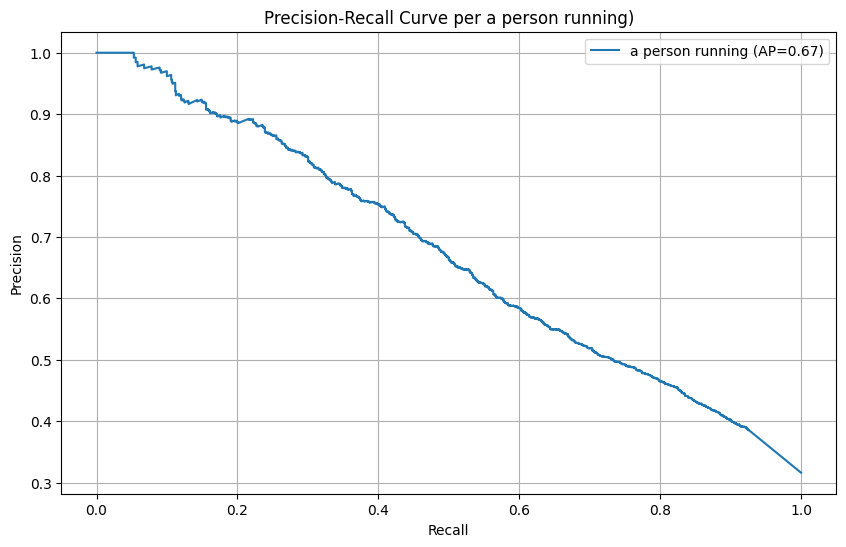

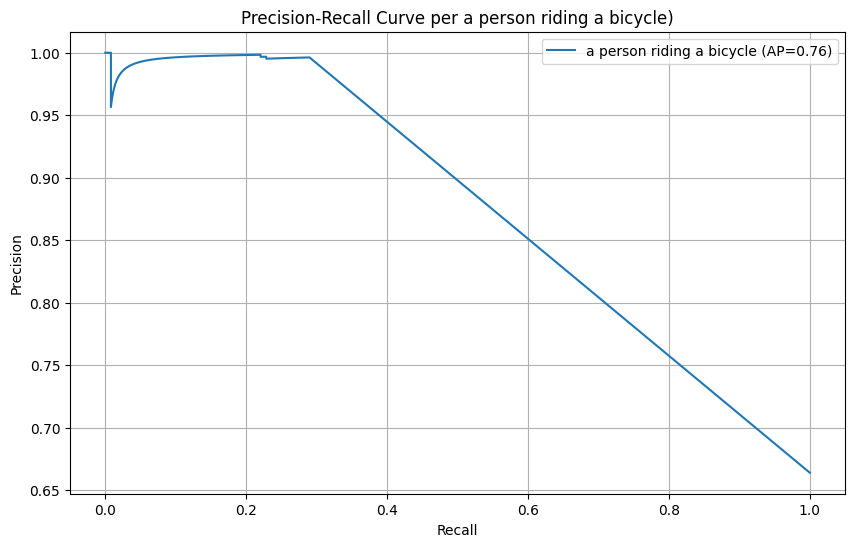

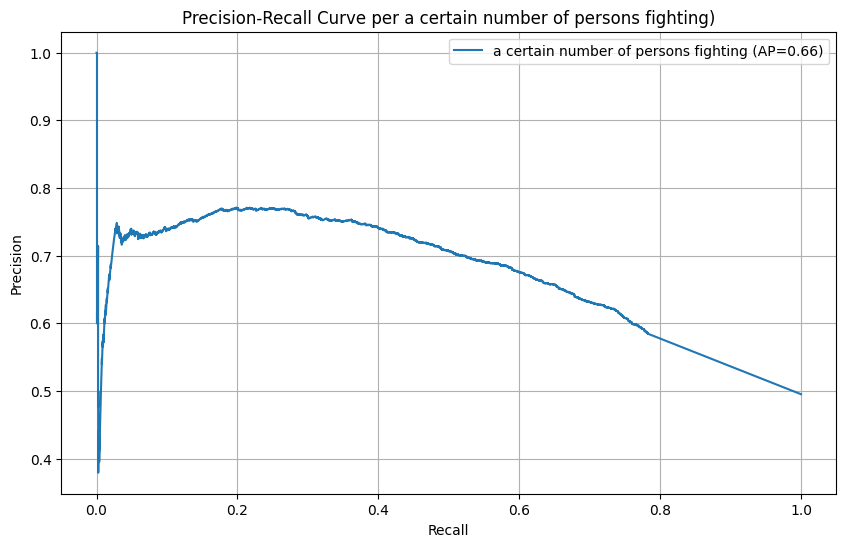

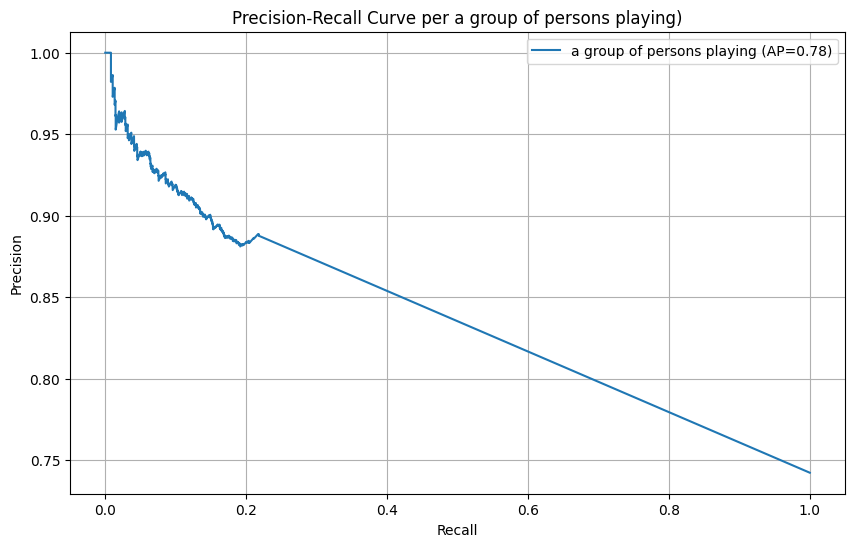

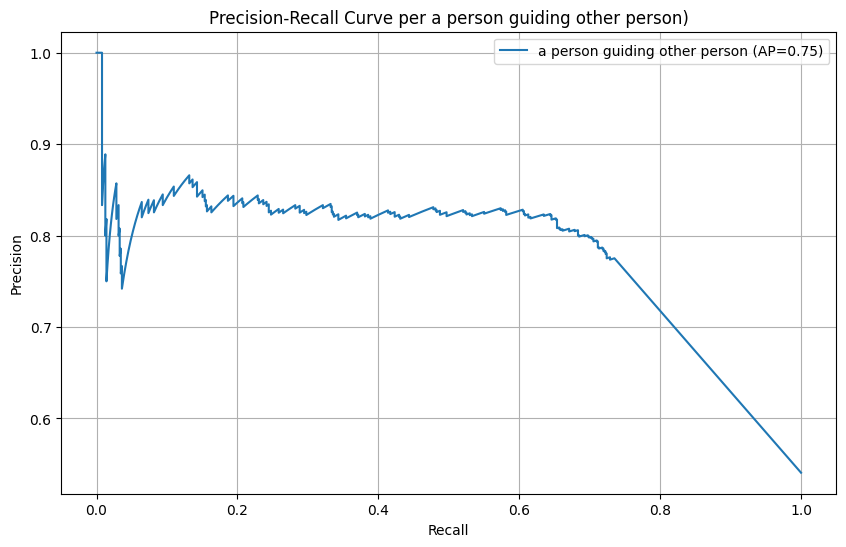

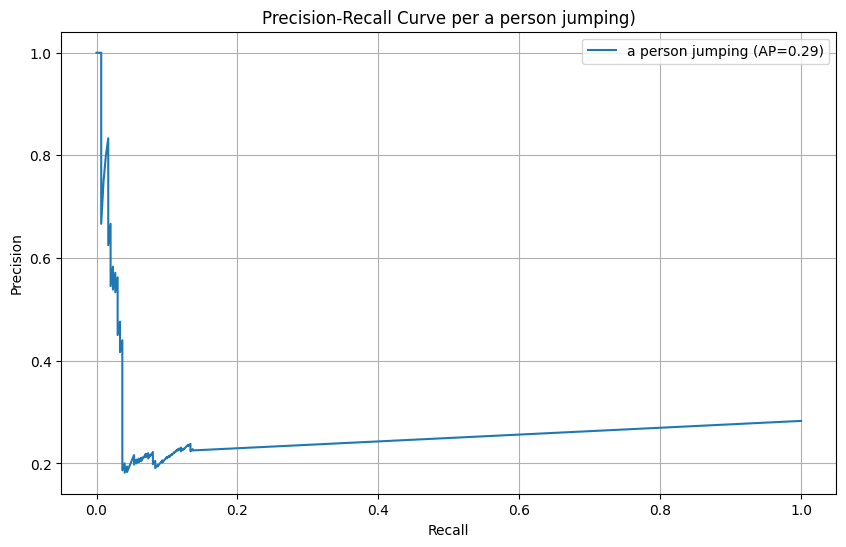

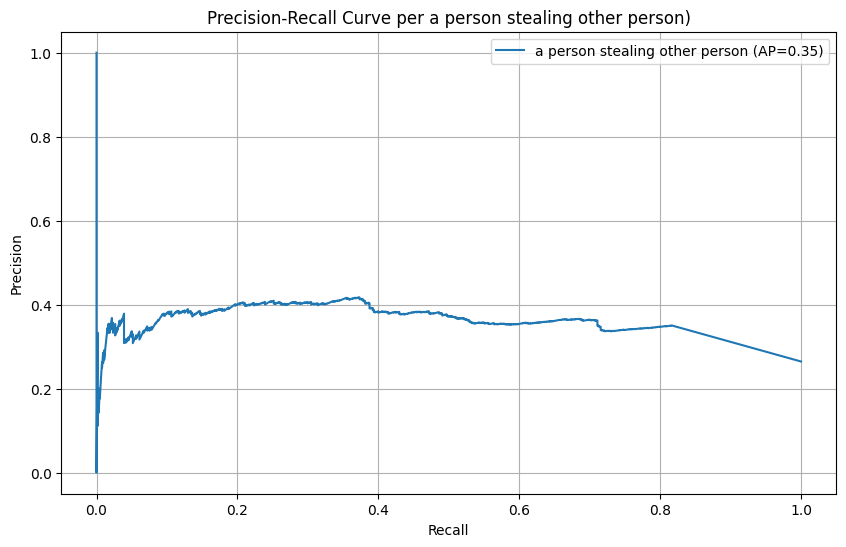

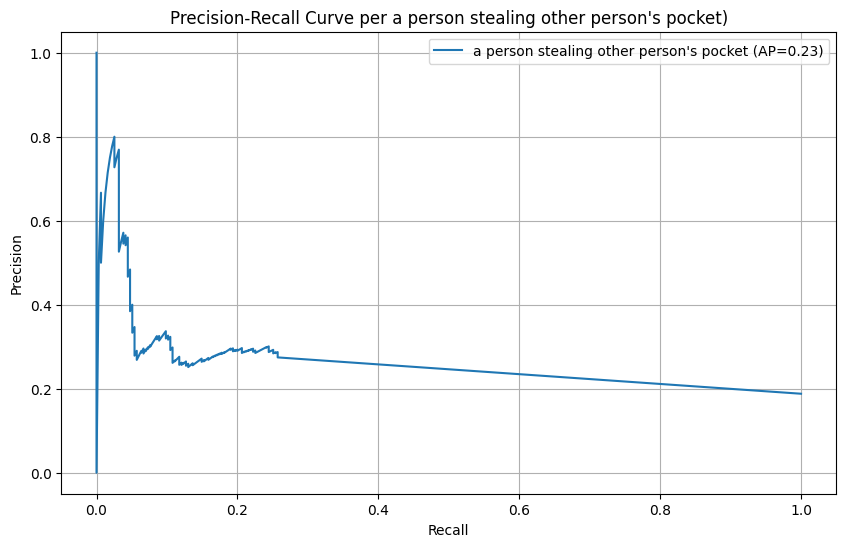

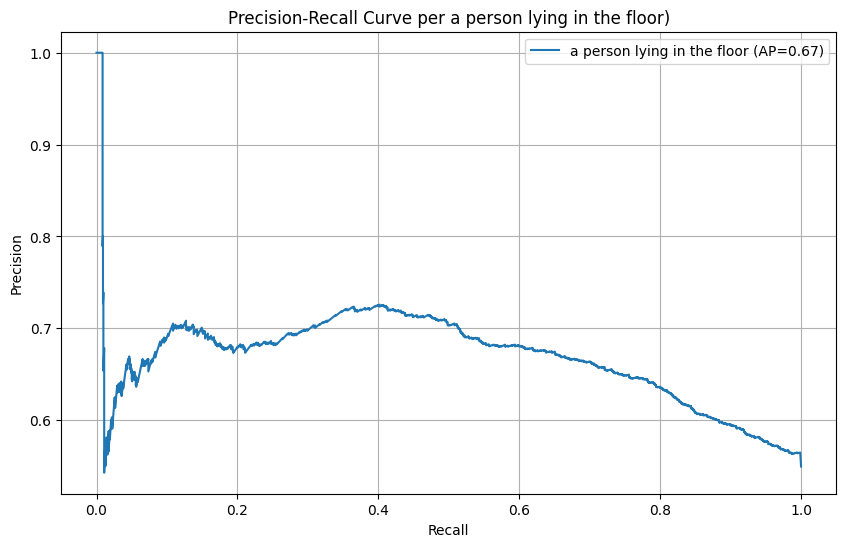

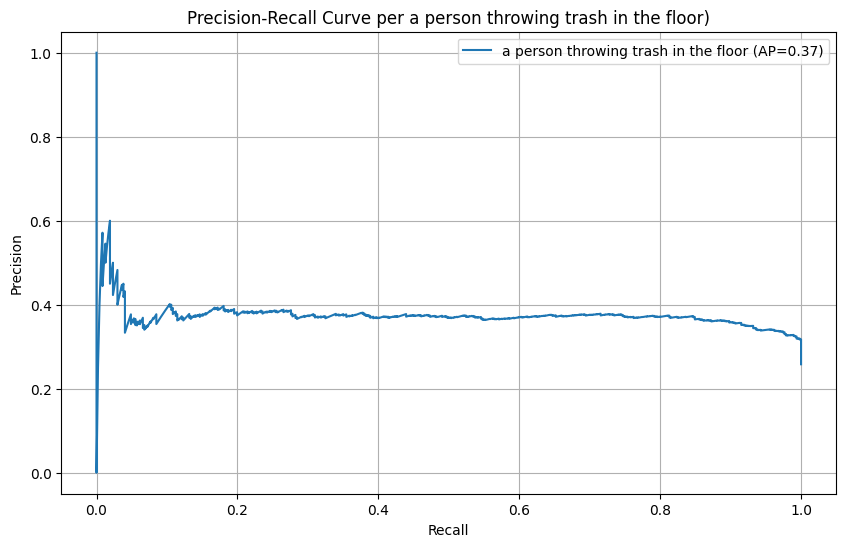

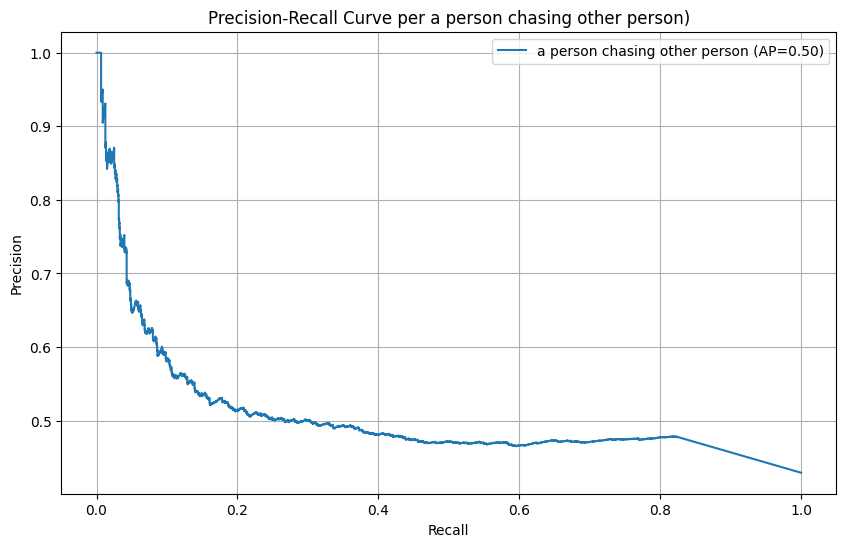

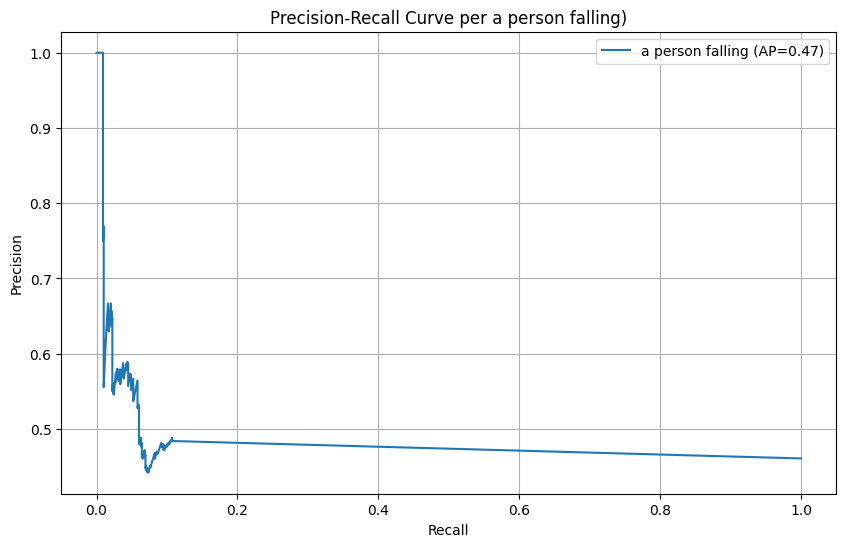

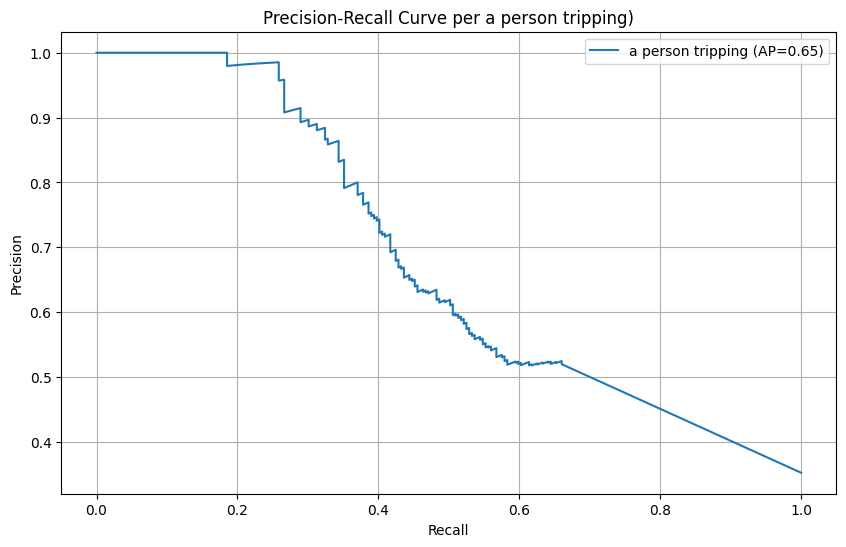

0.5514096035232136


In [4]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

ap_list = []
for event in df.Event.unique():
    gt = predictions[event]['GT']
    scores = predictions[event]['Scores']
    gt_arr = np.array(gt, dtype=float)
    scores_arr = np.array(scores, dtype=float)
    precision, recall, _ = precision_recall_curve(gt_arr, scores_arr)
    ap = average_precision_score(gt_arr, scores_arr)
    ap_list.append(ap)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label=f"{event} (AP={ap:.2f})")
    plt.title(f'Precision-Recall Curve per {event})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
plt.show()
mAP = np.mean(ap_list)
print(mAP)


In [5]:
rute_stored='/home/ubuntu/Tesis/Storage/Score_RulesNewScores'
files=os.listdir(rute_stored)
files = [f for f in files if f.endswith('.npy')]
df= pd.DataFrame(columns=['Name', 'Event', 'Mode', 'TP', 'FP', 'FN', 'TN'])

def check_metrics(scores, gt, threshold):
    tp, fp, fn, tn = 0, 0, 0, 0
    for i in range(len(scores)):
        scores[i] = 1 if scores[i] > threshold else 0
        tp += np.sum((scores[i] == 1) & (gt[i] == 1))
        fp += np.sum((scores[i] == 1) & (gt[i] == 0))  
        fn += np.sum((scores[i] == 0) & (gt[i] == 1))
        tn += np.sum((scores[i] == 0) & (gt[i] == 0))
    return tp, fp, fn, tn



for file in files:
    name= file.split('_CLIP_')[0]
    mode=int(file.split('_CLIP_')[1][0])
    event=file.split('_CLIP_')[1][2:].split('.')[0]
    info_stored=np.load(f"{rute_stored}/{file}", allow_pickle=True)
    frames_number=info_stored[0]
    scores=info_stored[1]
    gt=info_stored[2]
    threshold=df1.sort_values(by='F1 Score', ascending=False).head(1).iloc[0]['Threshold']
    #threshold = dic_thresholds.get(event, 0.5)  # Default threshold if not found
    tp, fp, fn, tn=check_metrics(scores, gt, threshold
                                )
    row = {
    'Name':name, 'Event':event, 'Mode':mode, 'TP':tp, 'FP':fp, 'FN':fn, 'TN':tn
    }
    df =pd.concat([df, pd.DataFrame([row])], ignore_index=True) 
    '''row= {'Name': name,
            'Event': event,
            'Mode': mode,
            'TP': np.sum((scores >= 0.5) & (gt == 1)),
            'FP': np.sum((scores >= 0.5) & (gt == 0)),
            'FN': np.sum((scores < 0.5) & (gt == 1)),
            'TN': np.sum((scores < 0.5) & (gt == 0))}
    df = df.append(row, ignore_index=True)'''
print(df)

        Name                                    Event Mode  TP   FP   FN   TN
0    4_087_1                         a person running    4  50   21    3   21
1    1_096_1                         a person running    4  12   13    7   27
2     000326                a person riding a bicycle    4  27    0   32  104
3    D043_01     a certain number of persons fighting    4  60   49    1  320
4    2_093_1               a group of persons playing    4  21    4  239  126
..       ...                                      ...  ...  ..  ...  ...  ...
247  2_077_1            a person chasing other person    4  24   38   10    0
248  3_093_1                         a person running    4  67  121    0   21
249  D149_03  a person stealing other person's pocket    4   8    2   70  265
250  3_088_1     a person throwing trash in the floor    4  13   64    2   40
251  3_104_1                         a person running    4  66   45    2   36

[252 rows x 7 columns]


In [6]:
df_respaldo=df.copy()
#df_respaldo=df_respaldo.loc[~df_respaldo["Name"].str.endswith("_1")] 
print(df_respaldo)
df_sum = df_respaldo.groupby(["Event", "Mode"])[
    ["TP", "FP", "FN", "TN"]
].sum().reset_index()

# Initialize precision, recall, accuracy with zeros
df_sum["Precision"] = 0.0
df_sum["Recall"] = 0.0
df_sum["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_sum["TP"] + df_sum["FP"]) != 0
df_sum.loc[mask_prec, "Precision"] = (
    df_sum.loc[mask_prec, "TP"] / (df_sum.loc[mask_prec, "TP"] + df_sum.loc[mask_prec, "FP"])
)

mask_recall = (df_sum["TP"] + df_sum["FN"]) != 0
df_sum.loc[mask_recall, "Recall"] = (
    df_sum.loc[mask_recall, "TP"] / (df_sum.loc[mask_recall, "TP"] + df_sum.loc[mask_recall, "FN"])
)

mask_acc = (df_sum["TP"] + df_sum["FP"] + df_sum["FN"] + df_sum["TN"]) != 0
df_sum.loc[mask_acc, "Accuracy"] = (
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "TN"]) /
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "FP"] + df_sum.loc[mask_acc, "FN"] + df_sum.loc[mask_acc, "TN"])
)
df_sum.drop(columns=['TP', 'FP', 'FN', 'TN'], inplace=True)
df_sum['F1'] = 2 * df_sum['Precision'].astype(float) * df_sum['Recall'].astype(float) / (df_sum['Precision'].astype(float) + df_sum['Recall'].astype(float))
df_sum['F1'].fillna(0, inplace=True)  # Handle division by zero
df_sum.drop(columns=['Event'], inplace=True)
df_sum=df_sum.groupby(["Mode"]).mean()
mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
df_sum.rename(index=mode_names, inplace=True)
print(df_sum)

        Name                                    Event Mode  TP   FP   FN   TN
0    4_087_1                         a person running    4  50   21    3   21
1    1_096_1                         a person running    4  12   13    7   27
2     000326                a person riding a bicycle    4  27    0   32  104
3    D043_01     a certain number of persons fighting    4  60   49    1  320
4    2_093_1               a group of persons playing    4  21    4  239  126
..       ...                                      ...  ...  ..  ...  ...  ...
247  2_077_1            a person chasing other person    4  24   38   10    0
248  3_093_1                         a person running    4  67  121    0   21
249  D149_03  a person stealing other person's pocket    4   8    2   70  265
250  3_088_1     a person throwing trash in the floor    4  13   64    2   40
251  3_104_1                         a person running    4  66   45    2   36

[252 rows x 7 columns]
     Precision    Recall  Accuracy      

/tmp/ipykernel_7163/2034563803.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6374711195127074 0.8876270173341303 0.47778077026663074
 0.5555555555555556 0.7858376511226253 0.22527472527472528
 0.5648358791030225 0.9962168978562421 0.3911404335532517
 0.34986595174262736 0.29277566539923955 0.35084882780921584
 0.5229357798165137]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_prec, "Precision"] = (
/tmp/ipykernel_7163/2034563803.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6843291995490417 0.21799765120375808 0.8255002326663564
 0.056179775280898875 0.713166144200627 0.13666666666666666
 0.9988505747126437 0.28884826325411334 0.9165194346289752 0.815625
 0.24444444444444444 0.921443736730361 0.6602316602316602]' has dtype incompatible with fl

In [7]:
def calculate_ap(precision, recall):
    # Sort by recall (ascending)
    sorted_indices = np.argsort(recall)
    precision = np.array(precision)[sorted_indices]
    recall = np.array(recall)[sorted_indices]

    # Pad with (0,0) and (1,0)
    precision = np.concatenate(([0], precision, [0]))
    recall = np.concatenate(([0], recall, [1]))

    # Compute AP as the area under the raw curve (no interpolation)
    ap = 0.0
    for i in range(1, len(recall)):
        delta_recall = recall[i] - recall[i - 1]
        ap += delta_recall * precision[i]

    return ap
df_check = df_respaldo.copy()

# Initialize precision, recall, accuracy with zeros
df_check["Precision"] = 0.0
df_check["Recall"] = 0.0
df_check["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_check["TP"] + df_check["FP"]) != 0
df_check.loc[mask_prec, "Precision"] = (
    df_check.loc[mask_prec, "TP"] / (df_check.loc[mask_prec, "TP"] + df_check.loc[mask_prec, "FP"])
)

mask_recall = (df_check["TP"] + df_check["FN"]) != 0
df_check.loc[mask_recall, "Recall"] = (
    df_check.loc[mask_recall, "TP"] / (df_check.loc[mask_recall, "TP"] + df_check.loc[mask_recall, "FN"])
)

mask_acc = (df_check["TP"] + df_check["FP"] + df_check["FN"] + df_check["TN"]) != 0
df_check.loc[mask_acc, "Accuracy"] = (
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "TN"]) /
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "FP"] + df_check.loc[mask_acc, "FN"] + df_check.loc[mask_acc, "TN"])
)
df_check['F1'] = 2 * df_check['Precision'].astype(float) * df_check['Recall'].astype(float) / (df_check['Precision'].astype(float) + df_check['Recall'].astype(float))
df_check['F1'].fillna(0, inplace=True)  # Handle division by zero
categories = df_check["Event"].unique()
# Separate rows by category
df_check = df_check.copy()
for column in df_check.select_dtypes(include=['category']).columns:
    df_check[column] = df_check[column].astype(str)
df_check.fillna(0, inplace=True)
category_dfs = {category: df_check[df_check["Event"] == category] for category in categories}

mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    #
    grouped = df1.groupby("Mode")
    # ----------------------------------------------------------------------
    # Ejecución del código
    ap_values = {}
    for mode, group in grouped:
        precision = np.array(group["Precision"].values)
        recall = np.array(group["Recall"].values)
        #print("Mode:", mode, "\n")
        #print("Precision:", precision, "Recall:", recall)
        # Comenta la siguiente línea para verificar si el error es aquí
        ap = calculate_ap(precision, recall)
        ap_values[mode] = ap
        #print(f'{mode} {categories[i]} AP: {ap:.4f}')
    mean_values = grouped[["Precision", "Recall",  "F1"]].mean()
    mean_values["AP"] = [ap_values[mode] for mode in mean_values.index]
    mean_values = mean_values[["AP"]]
    mAP_process.append(mean_values)
    # Plot the results
    mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
    mean_values.rename(index=mode_names, inplace=True)
    # plt.xlim(0.4)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values2 = pd.concat(mAP_process).groupby(level=0).mean()
print(mAP_values2)

          AP
Mode        
4     0.5136


/tmp/ipykernel_7163/4034585013.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.704225352112676 0.48 1.0 0.5504587155963303 0.84 0.34545454545454546
 0.2222222222222222 0.5961538461538461 1.0 0.5988700564971752
 0.4648910411622276 0.9887640449438202 1.0 0.5517241379310345
 0.41025641025641024 0.12727272727272726 0.42168674698795183 1.0
 0.22123893805309736 0.022222222222222223 1.0 0.6785714285714286 1.0
 0.804953560371517 0.6714975845410628 0.875 0.23684210526315788
 0.4594594594594595 0.5961538461538461 1.0 0.8846153846153846
 0.5746268656716418 0.5188679245283019 0.43478260869565216 1.0
 0.04712041884816754 0.5869565217391305 0.8088235294117647
 0.7047970479704797 1.0 0.2777777777777778 0.22289156626506024 1.0 0.48
 0.5384615384615384 1.0 0.5793650793650794 0.9166666666666666 0.5
 0.4594594594594595 1.0 1.0 0.27184466019417475 1.0 0.96875
 0.5460992907801419 1.0 0.42424242424242425 0.41836734693

In [8]:
df_fps= pd.read_csv("/home/ubuntu/Tesis/Results/TestingMCScoreRules.csv")
#df_fps= pd.read_csv("/home/ubuntu/Tesis/Results/TestingMCRulesNewScore.csv")
print(df_fps["Process time"].sum()/(60*60), "hours\n\n")
df_fps["Process time"] = df_fps["Process time"] / df_fps["Duration"]
df_fps.loc[df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        30.0 / df_fps["Process time"]
    )
df_fps.loc[~df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        25.0 / df_fps["Process time"]
    )
categories = df_fps["True Event"].unique()
category_dfs = {category: df_fps[df_fps["True Event"] == category] for category in categories}
print(categories)
mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    grouped = df1.groupby("Mode")
    mean_values = grouped[["Process time"]].mean()
    mean_values = mean_values[["Process time"]]
    mAP_process.append(mean_values)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values = pd.concat(mAP_process).groupby(level=0).mean()
print("\n\n", mAP_values)

2.16075098461575 hours


['a video of a person riding a bicycle on the street'
 'a video of multiple people engaged in a physical fight'
 'a video of a group of people playing a sport together'
 'a video of a person running'
 'a video of a person lying motionless on the ground'
 'a video of a person aggressively chasing another person'
 'a video of a person jumping high in the air with both feet'
 'a video of a person accidentally falling to the ground'
 'a video of a person gently guiding another person by the arm'
 'a video of a person stealing other person'
 'a video of a person deliberately throwing garbage on the ground'
 'a video of a person tripping over an obstacle'
 "a video of a person pickpocketing a wallet from someone's pocket"]


       Process time
Mode              
0        31.678137
